In [130]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import resnet34
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, f1_score
import random
import math
from tqdm import tqdm

In [131]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [132]:
torch.manual_seed(3407)
random.seed(3407)

In [133]:
# convert data to a normalized torch.FloatTensor
# transform = transforms.Compose([    transforms.ToTensor(), transforms.Normalize(
#         mean=[0.4914, 0.4822, 0.4465],
#         std=[0.2023, 0.1994, 0.2010])
# ])

# # convert data to a normalized torch.FloatTensor
# transform = transforms.Compose([
#     transforms.Resize((224, 224)), # Resize to 224x224 (height x width)
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225])
# ])
image_resize = 128
transform = transforms.Compose([
    transforms.Resize((image_resize, image_resize)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])


In [134]:
# loading the train data
batch_size = 32
#drop_last=True
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True )

#loading the test data
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False )


Files already downloaded and verified
Files already downloaded and verified


### Dense (fully connected) layer

In [135]:
class Dense:
    """
    A class representing a dense layer in a neural network.

    Args:
        n_inputs (int): The number of input features.
        n_neurons (int): The number of neurons in the layer.

    Attributes:
        weights (torch.Tensor): The weight matrix of shape (n_inputs, n_neurons)
            initialized using the He weight initialization method.
        biases (torch.Tensor): The bias vector of shape (1, n_neurons) initialized
            with zeros.
        prev_wchange (torch.Tensor): The previous weight change matrix of shape
            (n_inputs, n_neurons) initialized with zeros.
        prev_bchange (torch.Tensor): The previous bias change matrix of shape
            (1, n_neurons) initialized with zeros.

    Methods:
        forward(inputs): Performs forward propagation and returns the output
            of the layer.
        backward(output_error): Performs backward propagation and returns
            the input error.
    """
    def __init__(self, n_inputs, n_neurons):
        # He Weight Initialization
        self.weights = torch.randn(n_inputs, n_neurons) * torch.sqrt(torch.tensor(2. / n_inputs))
        self.biases = torch.zeros((1, n_neurons))
        self.weights = self.weights.to(device)
        self.biases = self.biases.to(device)
        self.prev_wchange = torch.zeros((n_inputs, n_neurons))
        self.prev_bchange = torch.zeros((1, n_neurons))
        self.prev_wchange = self.prev_wchange.to(device)
        self.prev_bchange = self.prev_bchange.to(device)

    
    def forward(self, inputs):
        """
        Performs forward propagation for the dense layer.

        Args:
            inputs (torch.Tensor): The input tensor of shape (batch_size, n_inputs).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, n_neurons).
        """
        self.inputs = inputs
        self.inputs = self.inputs.to(device)
        return torch.matmul(self.inputs, self.weights) + self.biases

    def backward(self, output_error):
        """
        Performs backward propagation for the dense layer.

        Args:
            output_error (torch.Tensor): The error tensor from the subsequent layer
                of shape (batch_size, n_neurons).

        Returns:
            torch.Tensor: The input error tensor of shape (batch_size, n_inputs).
        """
        # calculating errors
        self.inputs_error = torch.matmul(output_error, self.weights.T)
        self.inputs_error = self.inputs_error.to(device)
        self.weights_grad = torch.matmul(self.inputs.T, output_error)
        self.weights_grad = self.weights_grad.to(device)
        self.biases_grad = torch.sum(output_error, axis=0, keepdims=True)
        self.biases_grad =  self.biases_grad.to(device)
        return self.inputs_error


### Activation Layers


In [136]:
class ReLU:
    """
    A class representing the ReLU activation function.

    Methods:
        forward(inputs):
            Applies the ReLU activation function to the inputs and returns the result.

        backward(output_error):
            Calculates the input error for the ReLU activation function given the output error
            and returns it.
    """

    def forward(self, inputs):
        """
        Applies the ReLU activation function to the inputs.

        Args:
            inputs (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The tensor after applying the ReLU activation function.
        """
        self.inputs = inputs.clone()
        self.inputs = self.inputs.to(device)
        return torch.maximum(torch.zeros_like(inputs), inputs)

    def backward(self, output_error):
        """
        Calculates the input error for the ReLU activation function.

        Args:
            output_error (torch.Tensor): The error tensor from the subsequent layer.

        Returns:
            torch.Tensor: The input error tensor for the ReLU activation function.
        """
        self.inputs_error = output_error.clone()
        self.inputs_error = self.inputs_error.to(device)
        self.inputs_error[self.inputs <= 0] = 0
        return self.inputs_error



In [137]:
class Sigmoid:
    """
    A class representing the Sigmoid activation function.

    Methods:
        forward(inputs):
            Applies the Sigmoid activation function to the inputs and returns the result.

        backward(output_error):
            Calculates the input error for the Sigmoid activation function given the output error
            and returns it.
    """
    def forward(self,inputs):
        """
        Applies the Sigmoid activation function to the inputs.

        Args:
            inputs (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The tensor after applying the Sigmoid activation function.
        """
        self.outputs = 1 / (1 + np.exp(-inputs))
        self.outputs.to(device)
        return self.outputs

    def backward(self,output_error):
        """
        Calculates the input error for the Sigmoid activation function.

        Args:
            output_error (torch.Tensor): The error tensor from the subsequent layer.

        Returns:
            torch.Tensor: The input error tensor for the Sigmoid activation function.
        """
        self.outputs_grad = output_error * (1-self.outputs) * self.outputs
        self.outputs_grad = self.outputs_grad.to(device)
        return self.outputs_grad

In [138]:
class Softmax:
    """
    A class representing the Softmax activation function.

    Methods:
        forward(inputs):
            Applies the Softmax activation function to the inputs and returns the result.
    """
    def forward(self, inputs):
        """
        Applies the Softmax activation function to the inputs.

        Args:
            inputs (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The tensor after applying the Softmax activation function.
        """
        self.inputs = inputs.clone()
        self.inputs = self.inputs.to(device)
        exp_inputs = torch.exp(self.inputs - torch.max(self.inputs, dim=1, keepdim=True).values)
        exp_inputs = exp_inputs.to(device)
        self.outputs = exp_inputs / torch.sum(exp_inputs, dim=1, keepdim=True)
        self.outputs = self.outputs.to(device)
        return self.outputs



### Loss function

In [139]:
class Categorical_Cross_Entropy_loss:
    """
    A class representing the Categorical Cross-Entropy loss function.

    Methods:
        forward(softmax_output, class_label):
            Calculates the Categorical Cross-Entropy loss given the softmax output and class labels.

        backward(class_label):
            Calculates the input error for the Categorical Cross-Entropy loss function given the class labels.
    """
    def forward(self, softmax_output, class_label):
        """
        Calculates the Categorical Cross-Entropy loss given the softmax output and class labels.

        Args:
            softmax_output (torch.Tensor): The output tensor after applying the softmax activation function.
            class_label (torch.Tensor): The class labels tensor.

        Returns:
            torch.Tensor: The calculated Categorical Cross-Entropy loss.
        """

        # Apply softmax function to the output
        self.softmax_output = torch.clamp(softmax_output, 1e-12, 1. - 1e-12)
        self.softmax_output = self.softmax_output.to(device)
        N = softmax_output.shape[0]
        # Convert the class label to one-hot encoding
        self.class_label = torch.zeros_like(softmax_output)
        self.class_label = self.class_label.to(device)
        self.class_label[torch.arange(N), class_label] = 1
        # Calculate the cross-entropy loss
        self.loss = -torch.sum(self.class_label * torch.log(self.softmax_output)) / N
        self.loss = self.loss.to(device)
        return self.loss
    
    def backward(self, class_label):
        """
        Calculates the input error for the Categorical Cross-Entropy loss function given the class labels.

        Args:
            class_label (torch.Tensor): The class labels tensor.

        Returns:
            torch.Tensor: The input error tensor for the Categorical Cross-Entropy loss function.
        """

        # Calculate the derivative of the loss with respect to the softmax output
        N = self.softmax_output.shape[0]
        self.inputs_error = self.softmax_output.clone()
        self.inputs_error = self.inputs_error.to(device)
        self.inputs_error[torch.arange(N), class_label] -= 1
        self.inputs_error = self.inputs_error / N
        return self.inputs_error


### Optimizer

In [140]:
class FactorScheduler:
    """
    A class representing a learning rate scheduler based on a factor.

    Args:
        factor (float): The factor by which the learning rate is multiplied.
        stop_factor_lr (float): The minimum learning rate value.
        base_lr (float): The base learning rate.

    Methods:
        __call__(num_update):
            Calculates the learning rate based on the number of updates.

    """
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.001):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        """
        Calculates the learning rate based on the number of updates.

        Args:
            num_update (int): The current number of updates.

        Returns:
            float: The calculated learning rate.
        """
        #self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

class CosineScheduler:
    """
    A class representing a cosine learning rate scheduler.

    Args:
        max_update (int): The maximum number of updates.
        base_lr (float): The base learning rate.
        final_lr (float): The final learning rate.
        warmup_steps (int): The number of warm-up steps.
        warmup_begin_lr (float): The initial learning rate for warm-up.

    Methods:
        get_warmup_lr(epoch):
            Calculates the learning rate during warm-up phase.

        __call__(epoch):
            Calculates the learning rate based on the current epoch.
    """
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        """
        Calculates the learning rate during the warm-up phase.

        Args:
            epoch (int): The current epoch.

        Returns:
            float: The calculated learning rate during warm-up.
        """
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        """
        Calculates the learning rate based on the current epoch.

        Args:
            epoch (int): The current epoch.

        Returns:
            float: The calculated learning rate.
        """
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr
        #return self.base_lr_orig

In [141]:
class SGD:
    """
    A class representing the Stochastic Gradient Descent (SGD) optimizer.

    Args:
        learning_rate (float): The learning rate for the optimizer.
        momentum (float): The momentum factor for SGD.

    Methods:
        __call__(layer, num_epoch):
            Updates the weights and biases of the layer using SGD optimization.
    """
    def __init__(self, learning_rate=0.01, momentum = 0.9):
        self.learning_rate=learning_rate
        self.scheduler = CosineScheduler(max_update=20, base_lr=learning_rate, final_lr=0.0001) #FactorScheduler(factor=0.9, stop_factor_lr=0.0001, base_lr=learning_rate)
        self.momentum = momentum
    
    def __call__(self, layer, num_epoch):
        """
        Updates the weights and biases of the layer using SGD optimization.

        Args:
            layer (Dense): The layer to be updated.
            num_epoch (int): The current epoch.

        Returns:
            None
        """
        device = layer.weights.device
        layer.weights = layer.weights.to(device)
        layer.biases = layer.biases.to(device)
        cur_wchange = self.scheduler(num_epoch) * layer.weights_grad.to(device) + self.momentum * layer.prev_wchange.to(device)
        layer.weights -= cur_wchange
        cur_bchange = self.scheduler(num_epoch) * layer.biases_grad.to(device) + self.momentum * layer.prev_bchange.to(device)
        layer.biases -= cur_bchange
        layer.prev_wchange = cur_wchange
        layer.prev_bchange = cur_bchange
        



### Architecture

In [142]:
# feature_extractor = torchvision.models.resnet34(pretrained=True)
# feature_extractor = torch.nn.Sequential(*list(feature_extractor.children())[:-1])
# for param in feature_extractor.parameters():
#     param.requires_grad = False

feature_extractor = resnet34(pretrained=True)
num_features = feature_extractor.fc.in_features

for param in feature_extractor.parameters():
    param.requires_grad = False

feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)

In [144]:
#model
Layer1 = Dense(num_features,20)
Act1 = ReLU()
Layer2 = Dense(20,10)
Act2 = Softmax()
Loss = Categorical_Cross_Entropy_loss()
Optimizer = SGD(learning_rate=0.01,momentum=0.9)

In [104]:
history = {}
train_acc = {'Cosine Scheduler':[],'lr = 0.001':[]}
train_loss = {'Cosine Scheduler':[],'lr = 0.001':[]}
test_loss = {'Cosine Scheduler':[],'lr = 0.001':[]}
test_acc = {'Cosine Scheduler':[],'lr = 0.001':[]}

In [145]:
train_acc['Cosine Scheduler'] = []
train_loss['Cosine Scheduler'] = []
test_loss['Cosine Scheduler'] = []
test_acc['Cosine Scheduler'] = []

### Train

In [146]:

epochs = 20
y_predtr= torch.zeros(0,dtype=torch.long, device=device)
y_true_train = torch.zeros(0,dtype=torch.long, device=device)
y_predts= torch.zeros(0,dtype=torch.long, device=device)
y_true_test = torch.zeros(0,dtype=torch.long, device=device)
# Training loop
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_accuracy = 0
    epoch_test_loss = 0
    epoch_test_accuracy = 0

    # Training phase
    for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", colour="blue"):
        # Forward pass
        x_train, y_train = x_train.to(device), y_train.to(device)
        x = feature_extractor(x_train)
        x = Layer1.forward(x)
        x = Act1.forward(x)
        x = Layer2.forward(x)
        x = Act2.forward(x)
        loss = Loss.forward(x, y_train)

        # Report batch metrics
        y_predict_train = torch.argmax(x, dim=1)
        accuracy = torch.mean((y_train == y_predict_train).float())
        epoch_train_loss += loss.item()
        epoch_train_accuracy += accuracy.item()
        if epoch == epochs-1:
            y_predtr=torch.cat([y_predtr,y_predict_train.view(-1)])
            y_true_train=torch.cat([y_true_train,y_train.view(-1)])

        # Backward pass
        x = Loss.backward(y_train)
        #x = Act2.backward(x)
        x = Layer2.backward(x)
        x = Act1.backward(x)
        x = Layer1.backward(x)

        # Update parameters
        Optimizer(Layer1, epoch)
        Optimizer(Layer2, epoch)

    # Testing phase
    with torch.no_grad():
        for x_test, y_test in tqdm(test_dataloader, desc=f"Testing", colour="green"):
                # Forward pass
                x_test, y_test = x_test.to(device), y_test.to(device)
                x = feature_extractor(x_test)
                x = Layer1.forward(x)
                x = Act1.forward(x)
                x = Layer2.forward(x)
                x = Act2.forward(x)
                loss = Loss.forward(x, y_test)

                # Report batch metrics
                y_predict_test = torch.argmax(x, dim=1)
                accuracy = torch.mean((y_test == y_predict_test).float())
                epoch_test_loss += loss.item()
                epoch_test_accuracy += accuracy.item()
                if epoch == epochs-1:
                    y_predts=torch.cat([y_predts,y_predict_test.view(-1)])
                    y_true_test=torch.cat([y_true_test,y_test.view(-1)])
                
    # Report epoch metrics
    epoch_train_loss /= len(train_dataloader)
    epoch_train_accuracy /= len(train_dataloader)
    epoch_test_loss /= len(test_dataloader)
    epoch_test_accuracy /= len(test_dataloader)
    train_loss['Cosine Scheduler'].append(epoch_train_loss)
    train_acc['Cosine Scheduler'].append(epoch_train_accuracy)
    test_loss['Cosine Scheduler'].append(epoch_test_loss)
    test_acc['Cosine Scheduler'].append(epoch_test_accuracy)
    print(f'Epoch: {epoch+1}')
    print(f'Train Loss: {epoch_train_loss:.7f}')
    print(f'Train Accuracy: {epoch_train_accuracy:.7f}')
    print(f'Test Loss: {epoch_test_loss:.7f}')
    print(f'Test Accuracy: {epoch_test_accuracy:.7f}')
    print('--------------------------')


Testing: 100%|██████████| 313/313 [00:08<00:00, 34.82it/s]


Epoch: 1
Train Loss: 0.8464524
Train Accuracy: 0.7157110
Test Loss: 0.7041274
Test Accuracy: 0.7639776
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.22it/s]


Epoch: 2
Train Loss: 0.6973763
Train Accuracy: 0.7657550
Test Loss: 0.7423050
Test Accuracy: 0.7598842
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.49it/s]


Epoch: 3
Train Loss: 0.6706615
Train Accuracy: 0.7774712
Test Loss: 0.6908329
Test Accuracy: 0.7739617
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 31.99it/s]


Epoch: 4
Train Loss: 0.6527177
Train Accuracy: 0.7835693
Test Loss: 0.6682272
Test Accuracy: 0.7812500
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.64it/s]


Epoch: 5
Train Loss: 0.6351289
Train Accuracy: 0.7887876
Test Loss: 0.6660578
Test Accuracy: 0.7781550
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.60it/s]


Epoch: 6
Train Loss: 0.6206806
Train Accuracy: 0.7946857
Test Loss: 0.6792015
Test Accuracy: 0.7746605
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.58it/s]


Epoch: 7
Train Loss: 0.6148101
Train Accuracy: 0.7976847
Test Loss: 0.6689085
Test Accuracy: 0.7760583
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.73it/s]


Epoch: 8
Train Loss: 0.6006613
Train Accuracy: 0.7989044
Test Loss: 0.6240676
Test Accuracy: 0.7908347
--------------------------


Testing: 100%|██████████| 313/313 [00:08<00:00, 35.57it/s]


Epoch: 9
Train Loss: 0.5937943
Train Accuracy: 0.8022233
Test Loss: 0.6150888
Test Accuracy: 0.7930312
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.65it/s]


Epoch: 10
Train Loss: 0.5836093
Train Accuracy: 0.8045026
Test Loss: 0.6375780
Test Accuracy: 0.7869409
--------------------------


Testing: 100%|██████████| 313/313 [00:10<00:00, 30.92it/s]


Epoch: 11
Train Loss: 0.5717135
Train Accuracy: 0.8067218
Test Loss: 0.6275643
Test Accuracy: 0.7908347
--------------------------


Testing: 100%|██████████| 313/313 [00:10<00:00, 30.72it/s]


Epoch: 12
Train Loss: 0.5671327
Train Accuracy: 0.8082614
Test Loss: 0.6279824
Test Accuracy: 0.7923323
--------------------------


Testing: 100%|██████████| 313/313 [00:08<00:00, 35.57it/s]


Epoch: 13
Train Loss: 0.5537337
Train Accuracy: 0.8122001
Test Loss: 0.6160195
Test Accuracy: 0.7910343
--------------------------


Testing: 100%|██████████| 313/313 [00:10<00:00, 30.88it/s]


Epoch: 14
Train Loss: 0.5417750
Train Accuracy: 0.8143394
Test Loss: 0.6066112
Test Accuracy: 0.7964257
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 33.86it/s]


Epoch: 15
Train Loss: 0.5398629
Train Accuracy: 0.8161388
Test Loss: 0.5992711
Test Accuracy: 0.7975240
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.71it/s]


Epoch: 16
Train Loss: 0.5323998
Train Accuracy: 0.8196977
Test Loss: 0.6058535
Test Accuracy: 0.7959265
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.30it/s]


Epoch: 17
Train Loss: 0.5274316
Train Accuracy: 0.8191579
Test Loss: 0.5974126
Test Accuracy: 0.7981230
--------------------------


Testing: 100%|██████████| 313/313 [00:10<00:00, 31.20it/s]


Epoch: 18
Train Loss: 0.5207804
Train Accuracy: 0.8228167
Test Loss: 0.5903611
Test Accuracy: 0.8006190
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 33.65it/s]


Epoch: 19
Train Loss: 0.5190857
Train Accuracy: 0.8223768
Test Loss: 0.5898295
Test Accuracy: 0.8002196
--------------------------


Testing: 100%|██████████| 313/313 [00:08<00:00, 34.89it/s]

Epoch: 20
Train Loss: 0.5206092
Train Accuracy: 0.8245361
Test Loss: 0.5878719
Test Accuracy: 0.8019169
--------------------------


### Test

In [ ]:

# with torch.no_grad():
#         for x_test, y_test in tqdm(test_dataloader, desc=f"Testing", colour="green"):
#                 # Forward pass
#                 x_test, y_test = x_test.to(device), y_test.to(device)
#                 x = feature_extractor(x_test)
#                 x = Layer1.forward(x)
#                 x = Act1.forward(x)
#                 x = Layer2.forward(x)
#                 x = Act2.forward(x)
#                 loss = Loss.forward(x, y_test)

#                 # Report batch metrics
#                 y_predict_test = torch.argmax(x, dim=1)
#                 accuracy = torch.mean((y_test == y_predict_test).float())
#                 test_loss += loss.item()
#                 test_accuracy += accuracy.item()
#                 y_predts=torch.cat([y_predts,y_predict_test.view(-1)])
#                 y_true_test=torch.cat([y_true_test,y_test.view(-1)])
                
# test_loss /= len(test_dataloader)
# test_accuracy /= len(test_dataloader)
# print(f'Test Loss: {test_loss:.7f}')
# print(f'Test Accuracy: {test_accuracy:.7f}')

   

### Evaluation

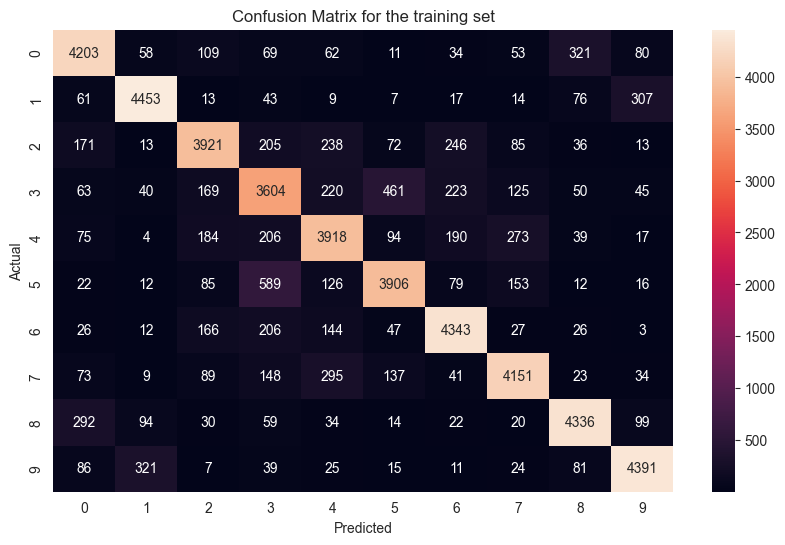

In [147]:
#Confusion Matrix for the training set
y_predtr_numpy = y_predtr.data.cpu().numpy()
y_train_numpy = y_true_train.data.cpu().numpy()
cm_train = confusion_matrix(y_train_numpy, y_predtr_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the training set")
plt.show()



In [148]:
print(f1_score(y_train_numpy, y_predtr_numpy, average='weighted'))

0.824573398183433


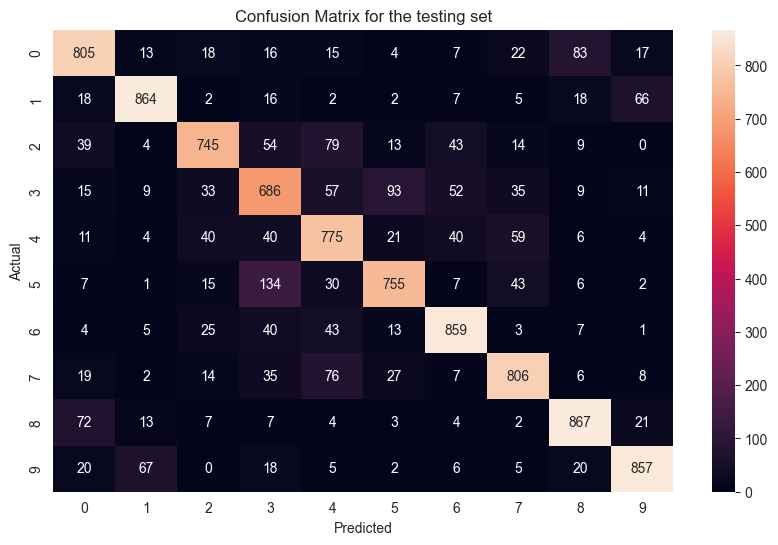

In [149]:
#Confusion Matrix for the test set
y_predts_numpy = y_predts.data.cpu().numpy()
y_test_numpy = y_true_test.data.cpu().numpy()
cm_train = confusion_matrix(y_test_numpy, y_predts_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the testing set")
plt.show()

In [150]:
print(f1_score(y_test_numpy, y_predts_numpy, average='weighted'))

0.8022531209444682


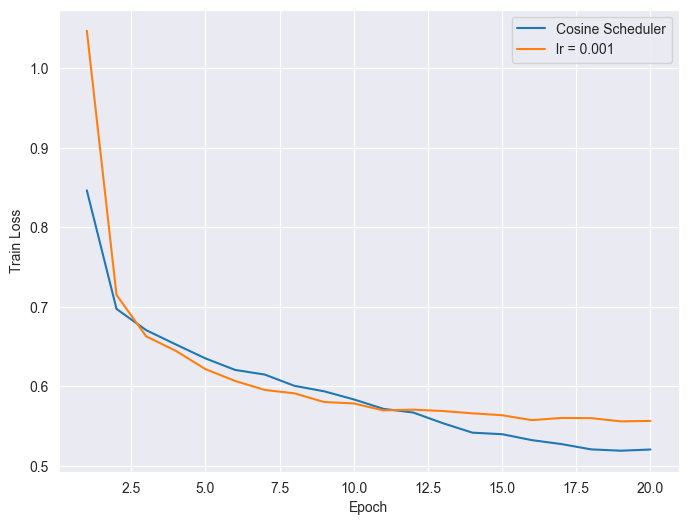

2


In [151]:
# Set up the plot
sb.set_style("darkgrid")
plt.figure(figsize=(8, 6))

# Loop through each key in the dictionary and plot a line
for key, data in train_loss.items():
    sb.lineplot(x=range(1, 21), y=data, label=key)

# Add labels and legend

plt.ylabel('Train Loss')
plt.xlabel('Epoch')

# Show the plot
plt.show()
print(len(train_acc))

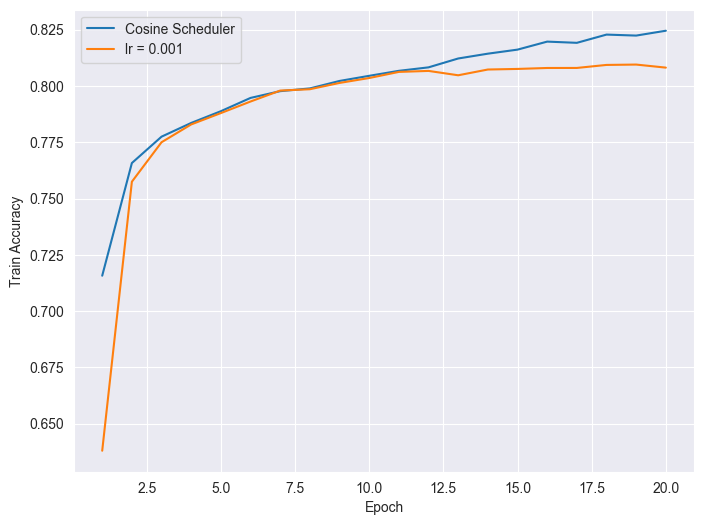

2


In [153]:
# train acc 
# Set up the plot
sb.set_style("darkgrid")
plt.figure(figsize=(8, 6))

# Loop through each key in the dictionary and plot a line
for key, data in train_acc.items():
    sb.lineplot(x=range(1, 21), y=data, label=key)

# Add labels and legend

plt.ylabel('Train Accuracy')
plt.xlabel('Epoch')

# Show the plot
plt.show()
print(len(train_acc))

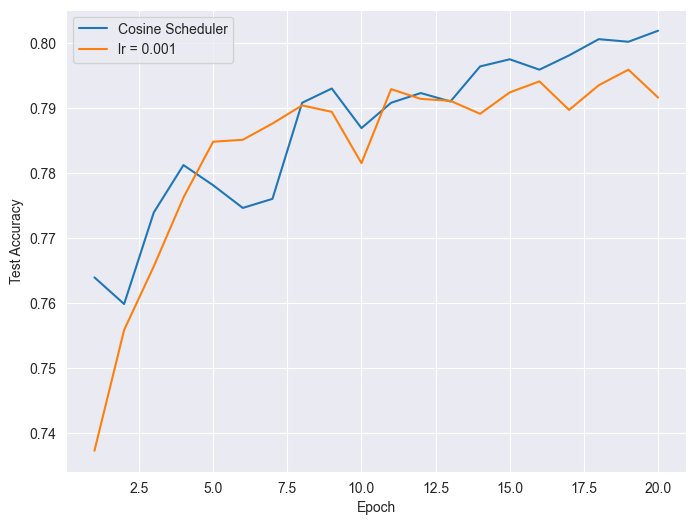

2


In [154]:
# test acc 
sb.set_style("darkgrid")
plt.figure(figsize=(8, 6))

# Loop through each key in the dictionary and plot a line
for key, data in test_acc.items():
    sb.lineplot(x=range(1, 21), y=data, label=key)

# Add labels and legend

plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')

# Show the plot
plt.show()
print(len(train_acc))

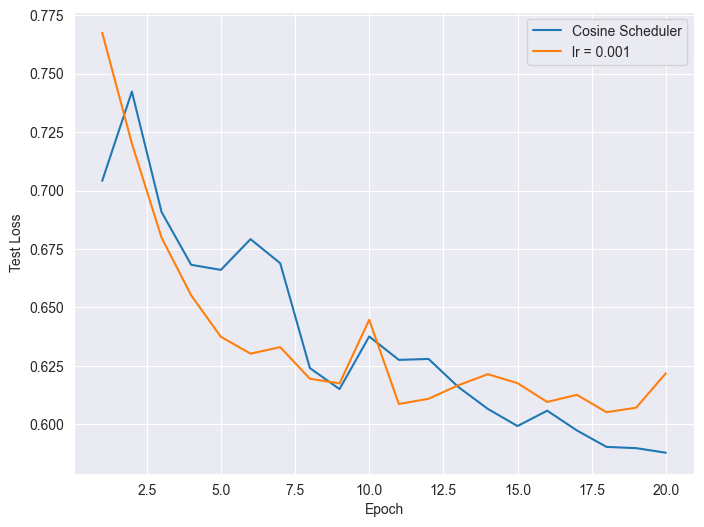

2


In [155]:
# test loss 
sb.set_style("darkgrid")
plt.figure(figsize=(8, 6))

# Loop through each key in the dictionary and plot a line
for key, data in test_loss.items():
    sb.lineplot(x=range(1, 21), y=data, label=key)

# Add labels and legend

plt.ylabel('Test Loss')
plt.xlabel('Epoch')

# Show the plot
plt.show()
print(len(train_acc))